In [6]:
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer as qv
import boulderopal as bo

bo.cloud.set_verbosity("QUIET")
plt.style.use(qv.get_qctrl_style())

controls_for_plots = lambda opt: {
    "$\\Omega$": opt["output"]["amplitude"],
    "$\\Delta$": opt["output"]["detuning"],
}


# Read and write helper functions, type independent.
def save_variable(file_name, var):
    """
    Save a single variable to a file using jsonpickle.
    """
    with open(file_name, "w+") as file:
        file.write(jsonpickle.encode(var))


def load_variable(file_name):
    """
    Load a variable from a file encoded with jsonpickle.
    """
    with open(file_name, "r+") as file:
        return jsonpickle.decode(file.read())

In [7]:
# Set parameters.
Omega_0 = 3.5 * 2 * np.pi * 1e6  # rad/s
Delta_0 = .377 * Omega_0
duration = .4 * 1e-6  # s
cutoff_frequency = Omega_0
segment_count = 256
sample_times = np.linspace(0, duration, segment_count)

# Define system operators.
basis_labels = ["00", "01", "10", "11", "0r", "r0", "1r", "r1", "rr"]

drive_operator = np.zeros((9, 9))
drive_operator[([1, 2], [4, 5])] = 1
drive_operator[([3, 3], [6, 7])] = np.sqrt(2)

detuning_operator = np.diag([0, 0, 0, 0, -1, -1, -1, -1, 0])

blockade_operator = np.zeros((9, 9))
blockade_operator[8, 8] = 1

# Components for the CZ operator.
h_00 = np.zeros((9, 9))
h_00[0, 0] = 1
h_01 = np.zeros((9, 9))
h_01[1, 1] = 1
h_01[2, 2] = 1
h_11 = np.zeros((9, 9))
h_11[3, 3] = -1


In [8]:
# Graph for blockade strengths B in rad/s.
def optimize_LP_gate(
    blockade_strength, cost_node, optimization_count=10, **robustness
):
    graph = bo.Graph()
    
    duration_op = graph.optimizable_scalar(10e-7, 10e-5, is_lower_unbounded=True, is_upper_unbounded=True)
    duration_op.name = "duration"
    
    phase_op = graph.optimization_variable(2, 0, 2 * np.pi, is_lower_unbounded=True, is_upper_unbounded=True, name = "laser_phases")
    
    Omega = graph.complex_pwc_signal(moduli=[Omega_0,Omega_0], phases=phase_op, duration = .4 * 1e-6 , name='amplitude')
    Delta = graph.complex_pwc_signal(moduli=[Delta_0,Delta_0], phases=phase_op, duration = .4 * 1e-6, name='detuning')
    

    
    # Create Hamiltonian.
    drive_term = graph.hermitian_part(Omega * drive_operator)
    delta_term = graph.hermitian_part(Delta * detuning_operator)
    hamiltonian = (drive_term + delta_term) * duration_op
    
    theta_s = graph.optimizable_scalar(
        lower_bound=0.0,
        upper_bound=2 * np.pi,
        is_lower_unbounded=True,
        is_upper_unbounded=True,
        name="theta_s",
    )
    
    cz_op = (
        h_00
        + graph.exp(1j * theta_s) * h_01
        + graph.exp(1j * (2 * theta_s + np.pi)) * h_11
    )
    target = graph.target(operator=cz_op)
    
    noise_list = []
    if robustness["dephasing"]:
        noise_list.append(detuning_operator / duration)
    if robustness["amplitude"]:
        noise_list.append(drive_term)
    penalty = robustness["decay"]

    
    infidelity = graph.infidelity_pwc(
        hamiltonian=hamiltonian,
        target=target,
        noise_operators=noise_list,
        name="infidelity",
    )

    unitary = graph.time_evolution_operators_pwc(
        hamiltonian=hamiltonian, sample_times=sample_times, name="unitary"
    ) 

    decay_cost = graph.sum(
        graph.abs(unitary[:, 4, 1]) ** 2
        + graph.abs(unitary[:, 5, 2]) ** 2
        + (1/np.sqrt(2))*graph.abs(unitary[:, 6, 3]) ** 2
        + (1/np.sqrt(2))*graph.abs(unitary[:, 7, 3]) ** 2
    ) * (0.25 * sample_times[1] / sample_times[-1])

    decay_cost.name = "decay cost"

    cost = graph.log(infidelity + penalty * decay_cost , name="cost")

    result = bo.run_optimization(
        graph=graph,
        output_node_names=[
            "theta_s",
            "amplitude",
            "detuning",
            "unitary",
            "infidelity",
            "decay cost",
            "duration",
            "laser_phases"
        ],
        cost_node_name=cost_node,
        optimization_count=optimization_count,
    )

    return result

In [9]:
result = optimize_LP_gate(
    blockade_strength=9999,
    cost_node="infidelity",
    dephasing=False,
    amplitude=False,
    decay=0.0,
)

Gate infidelity is 5.349e-10
Single-qubit phase is 6.283
Pulse Duration:  0.000
Pulse Phases:  [1.93747107 0.99426059]


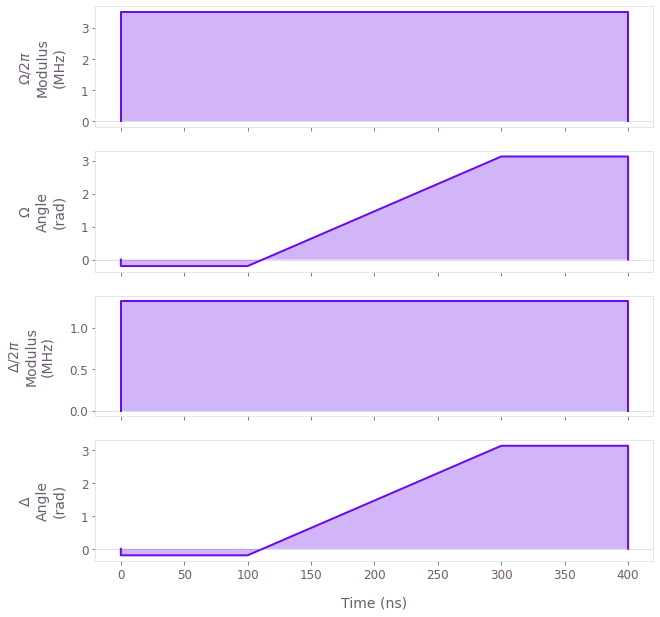

In [10]:
print("Gate infidelity is", f"{result['output']['infidelity']['value']:.3e}")
print("Single-qubit phase is", f"{result['output']['theta_s']['value']:.3f}")
print("Pulse Duration: ", f"{result['output']['duration']['value']:.3f}")
print("Pulse Phases: ", f"{(result['output']['laser_phases']['value'])/(np.pi)}")

qv.plot_controls(controls_for_plots(result), smooth=True)

In [11]:
# # Graph for blockade strengths B in rad/s.
# def optimize_LP_gate_v1(
#     blockade_strength, cost_node, optimization_count=10, **robustness
# ):
#     graph = bo.Graph()
#     tau = 0.175 * duration
#     t0 = duration / 4
#     a = np.exp(-((t0 / tau) ** 4))

#     times = np.linspace(0, duration / 2, segment_count)
#     amplitude = (
#         Omega_0
#         * (np.exp(-(((times - t0) / tau) ** 4)) - np.exp(-((t0 / tau) ** 4)))
#         / (1 - a)
#     )
#     detuning = Delta_0 * np.sin(2 * np.pi * (times - t0) / duration)

#     Omega = graph.pwc_signal(values=amplitude, duration=duration / 2)
#     Delta = graph.pwc_signal(values=detuning, duration=duration / 2)

#     # 2 pulses to implement the gate.
#     Omega = graph.time_concatenate_pwc([Omega, Omega], name="amplitude")
#     Delta = graph.time_concatenate_pwc([Delta, Delta], name="detuning")


#     # Create Hamiltonian.
#     drive_term = graph.hermitian_part(Omega * drive_operator)
#     delta_term = Delta * detuning_operator
#     blockade_term = blockade_strength * blockade_operator
#     hamiltonian = drive_term + delta_term + blockade_term

#     # Single-qubit rotation is a free parameter, can be optimized for best fidelity.
#     theta_s = graph.optimizable_scalar(
#         lower_bound=0.0,
#         upper_bound=2 * np.pi,
#         is_lower_unbounded=True,
#         is_upper_unbounded=True,
#         name="theta_s",
#     )

#     # Define target operation.
#     cz_op = (
#         h_00
#         + graph.exp(1j * theta_s) * h_01
#         + graph.exp(1j * (2 * theta_s + np.pi)) * h_11
#     )
#     target = graph.target(operator=cz_op)

#     # Define noise list to include robustness.
#     noise_list = []
#     if robustness["dephasing"]:
#         noise_list.append(detuning_operator / duration)
#     if robustness["amplitude"]:
#         noise_list.append(drive_term)
#     penalty = robustness["decay"]

#     infidelity = graph.infidelity_pwc(
#         hamiltonian=hamiltonian,
#         target=target,
#         noise_operators=noise_list,
#         name="infidelity",
#     )

#     unitary = graph.time_evolution_operators_pwc(
#         hamiltonian=hamiltonian, sample_times=sample_times, name="unitary"
#     )

#     # Node to store blockade value used (in Hz).
#     blockade = graph.abs(blockade_strength / 2 / np.pi)
#     blockade.name = "blockade"

#     decay_cost = graph.sum(
#         graph.abs(unitary[:, 4, 1]) ** 2
#         + graph.abs(unitary[:, 5, 2]) ** 2
#         + (1/np.sqrt(2))*graph.abs(unitary[:, 6, 3]) ** 2
#         + (1/np.sqrt(2))*graph.abs(unitary[:, 7, 3]) ** 2
#     ) * (0.25 * sample_times[1] / sample_times[-1])

#     decay_cost.name = "decay cost"

#     cost = graph.log(infidelity + penalty * decay_cost, name="cost")

#     result = bo.run_optimization(
#         graph=graph,
#         output_node_names=[
#             "theta_s",
#             "amplitude",
#             "detuning",
#             "unitary",
#             "infidelity",
#             "blockade",
#             "decay cost",
#         ],
#         cost_node_name=cost_node,
#         optimization_count=optimization_count,
#     )

#     return result